## Demo notebook for accessing NASADEM data on Azure

This notebook provides an example of accessing NASADEM data from blob storage on Azure, including (1) finding the NASADEM tile corresponding to a lat/lon coordinate, (2) retrieving that tile from blob storage, and (3) opening the downloaded file using the [NetCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) library, and (4) rendering the tile in a couple different ways.

NASADEM data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on NASADEM data also be situated in East US.  If you are using NASADEM data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports and environment

In [2]:
# Mostly-standard imports
import os
import tempfile
import numpy as np
import shutil
import urllib
import math
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

# Less-common-but-still-pip-installable imports
from netCDF4 import Dataset

# pip install progressbar2, not progressbar
import progressbar

# Storage locations are documented at http://aka.ms/ai4edata-nasadem
nasadem_account_name = 'nasademeuwest'
nasadem_container_name = 'nasadem-nc'
nasadem_account_url = 'https://' + nasadem_account_name + '.blob.core.windows.net'
nasadem_blob_root = nasadem_account_url + '/' + nasadem_container_name + '/v001/'

# A full list of files is available at:
#
# https://nasademeuwest.blob.core.windows.net/nasadem-nc/v001/index/file_list.txt
nasadem_file_index_url = nasadem_blob_root + 'index/nasadem_file_list.txt'

nasadem_content_extension = '.nc'
nasadem_file_prefix = 'NASADEM_NC_'

# This will contain just the .nc files
nasadem_file_list = None
                                   
temp_dir = os.path.join(tempfile.gettempdir(),'nasadem')
os.makedirs(temp_dir,exist_ok=True)

### Functions

In [3]:
class DownloadProgressBar():
    """
    https://stackoverflow.com/questions/37748105/how-to-use-progressbar-module-with-urlretrieve
    """
    
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(max_value=total_size)
            self.pbar.start()
            
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()
            

def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')    
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(
            os.path.basename(url)))
        return destination_filename
    print('Downloading file {} to {}'.format(os.path.basename(url),
                                             destination_filename),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename


def lat_lon_to_nasadem_tile(lat,lon):
    """
    Get the NASADEM file name for a specified latitude and longitude
    """
    
    # A tile name looks like:
    #
    # NASADEM_NUMNC_n00e016.nc
    #
    # The translation from lat/lon to that string is represented nicely at:
    #
    # https://dwtkns.com/srtm30m/

    # Force download of the file list
    get_nasadem_file_list()
        
    ns_token = 'n' if lat >=0 else 's'
    ew_token = 'e' if lon >=0 else 'w'
    
    lat_index = abs(math.floor(lat))
    lon_index = abs(math.floor(lon))
    
    lat_string = ns_token + '{:02d}'.format(lat_index)
    lon_string = ew_token + '{:03d}'.format(lon_index)
    
    filename =  nasadem_file_prefix + lat_string + lon_string + \
        nasadem_content_extension

    if filename not in nasadem_file_list:
        print('Lat/lon {},{} not available'.format(lat,lon))
        filename = None
    
    return filename


def get_nasadem_file_list():
    """
    Retrieve the full list of NASADEM tiles
    """
    
    global nasadem_file_list
    if nasadem_file_list is None:
        nasadem_file = download_url(nasadem_file_index_url)
        with open(nasadem_file) as f:
            nasadem_file_list = f.readlines()
            nasadem_file_list = [f.strip() for f in nasadem_file_list]
            nasadem_file_list = [f for f in nasadem_file_list if \
                                 f.endswith(nasadem_content_extension)]
    return nasadem_file_list

### Download a NASADEM tile for a known lat/lon

In [4]:
# Interesting places for looking at SRTM data
everest = [27.9881,86.9250]
seattle = [47.6062,-122.3321]
grand_canyon = [36.101690, -112.107676]
mount_fuji = [35.3606, 138.7274]
mont_blanc = [45.832778, 6.865000]
invalid = [-15.1,41]

tile_of_interest = mount_fuji

tile_name = lat_lon_to_nasadem_tile(tile_of_interest[0],tile_of_interest[1])
url = nasadem_blob_root + tile_name
fn = download_url(url,progress_updater=DownloadProgressBar())

100% (26000266 of 26000266) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000266 bytes.


### Load and plot the tile

Height ranges from -18 meters to 3756 meters


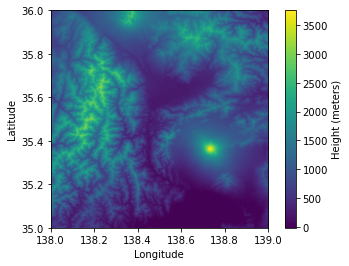

In [5]:
fh = Dataset(fn, mode='r')
heights = fh['NASADEM_HGT'][:]
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]

min_height = np.min(heights)
max_height = np.max(heights)
height_units = fh.variables['NASADEM_HGT'].units

fh.close()

print('Height ranges from {} {} to {} {}'.format(min_height,height_units,
      max_height,height_units))

extent = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]
plt.imshow(heights,extent=extent)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cb = plt.colorbar()
cb.set_label('Height ({})'.format(height_units))

### Also plot on a basemap

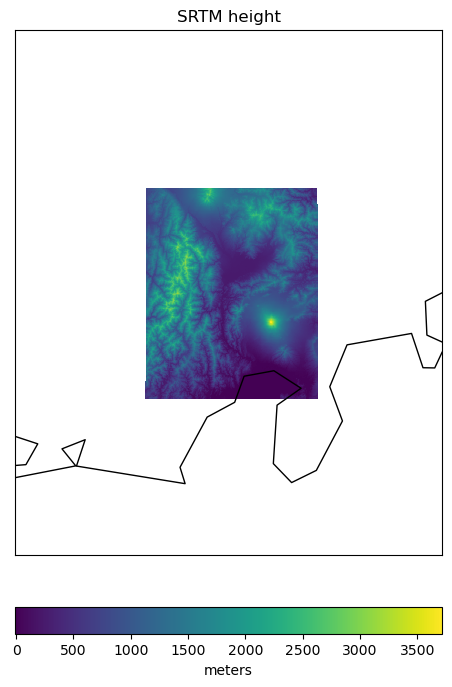

In [7]:
import warnings; warnings.filterwarnings("ignore")

# To plot on a basemap, we'll want to downsample the data substantially
ds_factor = 10

# Show a little space around each edge on the basemap (this is in lat/lon units)
expansion_distance = 0.75

lon_0 = lons.mean()
lat_0 = lats.mean()
lons_ds = lons[::ds_factor]
lats_ds = lats[::ds_factor]
heights_ds = heights[::ds_factor,::ds_factor,]

# Convert to a 2D grid for plotting
lon_plot, lat_plot = np.meshgrid(lons_ds, lats_ds)

plt.figure(num=None, figsize=(8, 8), dpi=100)

m = Basemap(projection='stere',resolution='l',
            lat_ts=lat_0,lat_0=lat_0,lon_0=lon_0,
            llcrnrlon=extent[0]-expansion_distance, 
            llcrnrlat=extent[2]-expansion_distance,
            urcrnrlon=extent[1]+expansion_distance,
            urcrnrlat=extent[3]+expansion_distance)

xi, yi = m(lon_plot, lat_plot)

cs = m.pcolor(xi,yi,np.squeeze(heights_ds))

# Add grid lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add coastlines and state/country borders

# drawcoastlines() fails when no coastlines are visible
try:
    m.drawcoastlines()
except:
    pass
m.drawstates()
m.drawcountries()

cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(height_units)
plt.title('SRTM height')
plt.show()

### Clean up temporary files

In [8]:
shutil.rmtree(temp_dir)